In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML, display
import tabulate
import re
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
api_data = pd.read_csv("../../data/api_data.csv")

print(f"CSV has {len(api_data)} projects.")

CSV has 2731 projects.


In [3]:
api_data

,id,project,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,isFork,deleteBranchOnMerge,...,issues,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags
0,3518171,sebastianbenz/Jnario,NaN,10372,False,sebastianbenz/Jnario,/sebastianbenz/Jnario,133.0,False,False,...,146.0,35.0,0.0,19.0,32.0,37.0,1303.0,9.0,19.0,20.0
1,3661343,CCI-MIT/XCoLab,NaN,6889,False,CCI-MIT/XCoLab,/CCI-MIT/XCoLab,15.0,False,False,...,9.0,288.0,0.0,8.0,10.0,10.0,10045.0,25.0,97.0,0.0
2,2524488,apache/accumulo,NaN,5141,False,apache/accumulo,/apache/accumulo,864.0,False,False,...,628.0,1394.0,0.0,88.0,333.0,351.0,10876.0,131.0,3.0,38.0
3,65885,android/platform_frameworks_base,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,False,False,...,0.0,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0
4,1006053,TeamDev-Ltd/OpenFaces,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,False,False,...,173.0,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,3467722,pingpongboss/Phone-Modem,NaN,1,False,pingpongboss/Phone-Modem,/pingpongboss/Phone-Modem,30.0,False,False,...,0.0,0.0,0.0,5.0,9.0,9.0,24.0,2.0,1.0,0.0
2727,3468682,htdvisser/Skt,NaN,1,True,htdvisser/Skt,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2728,2130242,justjoheinz/STLDroid,NaN,1,False,justjoheinz/STLDroid,/justjoheinz/STLDroid,10.0,False,False,...,1.0,0.0,0.0,1.0,4.0,4.0,24.0,1.0,1.0,5.0
2729,3355503,SpoutDev/BukkitBridge,NaN,1,False,SpoutDev/BukkitBridge,/SpoutDev/BukkitBridge,19.0,False,False,...,0.0,53.0,0.0,17.0,9.0,9.0,248.0,21.0,1.0,0.0


In [4]:
conflicting_merges_per_project = pd.read_csv("../../data/number_conflicting_merges_project_selected.csv")
conflicting_merges_per_project

,id,project,nr_conflicting_merges
0,65885,android/platform_frameworks_base,3355
1,185026,freenet/fred,237
2,206437,apache/directory-server,18
3,217482,Ramblurr/Anki-Android,155
4,223355,alexo/wro4j,395
5,507775,elastic/elasticsearch,235
6,726492,getrailo/railo,163
7,762119,atlasapi/atlas,418
8,961036,hibernate/hibernate-orm,27
9,1006053,TeamDev-Ltd/OpenFaces,178


In [5]:
merges_per_project = pd.read_csv("../../data/number_merges_project_selected.csv")
merges_per_project

,id,project,nr_merges
0,65885,android/platform_frameworks_base,156732
1,185026,freenet/fred,1076
2,206437,apache/directory-server,50
3,217482,Ramblurr/Anki-Android,952
4,223355,alexo/wro4j,1458
5,507775,elastic/elasticsearch,2442
6,726492,getrailo/railo,671
7,762119,atlasapi/atlas,2284
8,961036,hibernate/hibernate-orm,152
9,1006053,TeamDev-Ltd/OpenFaces,611


In [6]:
merges_csv = pd.merge(merges_per_project, conflicting_merges_per_project, on='project', how='inner')
merges_csv = merges_csv.drop(columns=['id_y'])
merges_csv = merges_csv.rename(columns={'id_x':'id'})
merges_csv

,id,project,nr_merges,nr_conflicting_merges
0,65885,android/platform_frameworks_base,156732,3355
1,185026,freenet/fred,1076,237
2,206437,apache/directory-server,50,18
3,217482,Ramblurr/Anki-Android,952,155
4,223355,alexo/wro4j,1458,395
5,507775,elastic/elasticsearch,2442,235
6,726492,getrailo/railo,671,163
7,762119,atlasapi/atlas,2284,418
8,961036,hibernate/hibernate-orm,152,27
9,1006053,TeamDev-Ltd/OpenFaces,611,178


In [7]:
selected_dataset_2 = pd.read_csv("../../data/selected_dataset_2.csv")
selected_dataset_2

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,...,Method signature,Other,Blank,Array initializer,Switch statement,Static initializer,Do statement,Method declaration,Attribute,Catch clause
0,777206,ConcatenationV2V1,427,436,434,"Attribute, Comment, Method invocation",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,1,0
1,777207,Version 1,2826,2871,2827,"Comment, Method declaration",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,1,0,0
2,777216,Combination,2458,2465,2463,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
3,777218,Combination,2476,2482,2479,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
4,777221,Version 1,750,753,751,"Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70281,1658387,Version 1,173,227,200,"Method signature, Try statement",https://github.com/allwinner-ics/platform_fram...,allwinner-ics/platform_frameworks_base,allwinner-ics,platform_frameworks_base,...,1,0,0,0,0,0,0,0,0,0
70282,1658389,Version 1,833,841,837,"Method invocation, Method signature, Return st...",https://github.com/allwinner-ics/platform_fram...,allwinner-ics/platform_frameworks_base,allwinner-ics,platform_frameworks_base,...,1,0,0,0,0,0,0,0,0,0
70283,1658390,Version 1,859,875,867,"Comment, Method invocation, Method signature, ...",https://github.com/allwinner-ics/platform_fram...,allwinner-ics/platform_frameworks_base,allwinner-ics,platform_frameworks_base,...,1,0,0,0,0,0,0,0,0,0
70284,1658391,Version 1,890,906,898,"Comment, Method invocation, Method signature, ...",https://github.com/allwinner-ics/platform_fram...,allwinner-ics/platform_frameworks_base,allwinner-ics,platform_frameworks_base,...,1,0,0,0,0,0,0,0,0,0


In [8]:
selected_dataset_2.columns

Index(['chunk_id', 'developerdecision', 'line_start', 'line_end',
       'line_separator', 'kind_conflict', 'url', 'project', 'project_user',
       'project_name', 'path', 'file_name', 'sha', 'leftsha', 'rightsha',
       'basesha', 'left_lines_added', 'left_lines_removed',
       'right_lines_added', 'right_lines_removed', 'conclusion_delay',
       'keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve',
       'keyword_document', 'keyword_refactor', 'keyword_update', 'keyword_add',
       'keyword_remove', 'keyword_use', 'keyword_delete', 'keyword_change',
       'leftCC', 'rightCC', 'fileCC', 'chunkAbsSize', 'chunkRelSize',
       'chunkPosition', 'fileSize', 'chunk_left_abs_size',
       'chunk_left_rel_size', 'chunk_right_abs_size', 'chunk_right_rel_size',
       'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2',
       'Different devs', 'Same devs', 'Devs intersection', 'Commits 1',
       'Commits 2', 'Changed files 1', 'Changed files 2',
       'Changed 

In [9]:
chunks_per_project = selected_dataset_2.groupby(['project']).count()['chunk_id']
chunks_per_project

project
AOKP/frameworks_base_disabled                                     2498
CCI-MIT/XCoLab                                                    6889
CloudStack-extras/CloudStack-archive                              1779
IceColdSandwich/android_frameworks_base                           2240
Ramblurr/Anki-Android                                             1115
RealVNC/android-frameworks-base-with-screenshot-tweaks            2836
SINTEF-9012/ThingML                                               1277
TeamDev-Ltd/OpenFaces                                             3723
Unidata/thredds                                                   1442
adetaylor/android-frameworks-base-with-remote-control-service     2240
alexo/wro4j                                                       2078
alkacon/opencms-core                                              1153
allwinner-ics/platform_frameworks_base                            2224
android/platform_frameworks_base                                  444

In [10]:
join_api_selected = pd.merge(api_data, chunks_per_project, on='project', how='inner')
join_api_selected[['project_actual_ownername','chunks', 'chunk_id']]

,project_actual_ownername,chunks,chunk_id
0,sebastianbenz/Jnario,10372,10372
1,CCI-MIT/XCoLab,6889,6889
2,apache/accumulo,5141,5141
3,aosp-mirror/platform_frameworks_base,4446,4446
4,TeamDev-Archive/OpenFaces,3723,3723
5,VNCAutomotive/android-frameworks-base-with-scr...,2836,2836
6,jgralab/jgralab,2590,2590
7,AOKP/frameworks_base_disabled,2498,2498
8,adetaylor/android-frameworks-base-with-remote-...,2240,2240
9,IceColdSandwich/android_frameworks_base,2240,2240


## Characteristics of the Projects

In [11]:
selected_projects = api_data[api_data.chunks >= 1000]
selected_projects

,id,project,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,isFork,deleteBranchOnMerge,...,issues,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags
0,3518171,sebastianbenz/Jnario,NaN,10372,False,sebastianbenz/Jnario,/sebastianbenz/Jnario,133.0,False,False,...,146.0,35.0,0.0,19.0,32.0,37.0,1303.0,9.0,19.0,20.0
1,3661343,CCI-MIT/XCoLab,NaN,6889,False,CCI-MIT/XCoLab,/CCI-MIT/XCoLab,15.0,False,False,...,9.0,288.0,0.0,8.0,10.0,10.0,10045.0,25.0,97.0,0.0
2,2524488,apache/accumulo,NaN,5141,False,apache/accumulo,/apache/accumulo,864.0,False,False,...,628.0,1394.0,0.0,88.0,333.0,351.0,10876.0,131.0,3.0,38.0
3,65885,android/platform_frameworks_base,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,False,False,...,0.0,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0
4,1006053,TeamDev-Ltd/OpenFaces,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,False,False,...,173.0,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0
5,4212733,RealVNC/android-frameworks-base-with-screensho...,VNCAutomotive/android-frameworks-base-with-scr...,2836,False,VNCAutomotive/android-frameworks-base-with-scr...,/VNCAutomotive/android-frameworks-base-with-sc...,4.0,False,False,...,0.0,0.0,0.0,18.0,3.0,3.0,62550.0,83.0,11.0,1.0
6,3405664,jgralab/jgralab,NaN,2590,False,jgralab/jgralab,/jgralab/jgralab,15.0,False,False,...,8.0,0.0,0.0,13.0,3.0,3.0,7630.0,11.0,8.0,70.0
7,2902099,AOKP/frameworks_base_disabled,NaN,2498,False,AOKP/frameworks_base_disabled,/AOKP/frameworks_base_disabled,98.0,False,False,...,1.0,77.0,0.0,8.0,69.0,75.0,78600.0,210.0,3.0,1.0
8,3518362,adetaylor/android-frameworks-base-with-remote-...,NaN,2240,False,adetaylor/android-frameworks-base-with-remote-...,/adetaylor/android-frameworks-base-with-remote...,2.0,False,False,...,0.0,0.0,0.0,1.0,1.0,2.0,62743.0,83.0,3.0,0.0
9,3129899,IceColdSandwich/android_frameworks_base,NaN,2240,False,IceColdSandwich/android_frameworks_base,/IceColdSandwich/android_frameworks_base,13.0,False,False,...,0.0,3.0,0.0,1.0,3.0,3.0,63311.0,204.0,7.0,0.0


In [12]:
join_api_merges_csv = pd.merge(merges_csv, selected_projects, on='project', how='inner')
join_api_merges_csv = join_api_merges_csv.drop(columns=['id_y'])
join_api_merges_csv = join_api_merges_csv.rename(columns={'id_x':'id'})

join_api_merges_csv

,id,project,nr_merges,nr_conflicting_merges,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,...,issues,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags
0,65885,android/platform_frameworks_base,156732,3355,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,...,0.0,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0
1,185026,freenet/fred,1076,237,NaN,1584,False,freenet/fred,/freenet/fred,685.0,...,0.0,722.0,48.0,87.0,161.0,171.0,30800.0,71.0,99.0,2015.0
2,206437,apache/directory-server,50,18,NaN,1056,False,apache/directory-server,/apache/directory-server,82.0,...,0.0,41.0,0.0,24.0,60.0,63.0,9797.0,39.0,95.0,51.0
3,217482,Ramblurr/Anki-Android,952,155,NaN,1115,False,Ramblurr/Anki-Android,/Ramblurr/Anki-Android,80.0,...,0.0,0.0,0.0,16.0,33.0,309.0,4888.0,31.0,4.0,0.0
4,223355,alexo/wro4j,1458,395,NaN,2078,False,alexo/wro4j,/alexo/wro4j,444.0,...,125.0,103.0,0.0,35.0,113.0,114.0,3619.0,37.0,55.0,46.0
5,507775,elastic/elasticsearch,2442,235,NaN,1557,False,elastic/elasticsearch,/elastic/elasticsearch,54627.0,...,26815.0,45097.0,44.0,2781.0,19045.0,19739.0,58486.0,3118.0,118.0,293.0
6,726492,getrailo/railo,671,163,NaN,1018,False,getrailo/railo,/getrailo/railo,246.0,...,0.0,441.0,0.0,43.0,86.0,87.0,3990.0,16.0,6.0,164.0
7,762119,atlasapi/atlas,2284,418,NaN,1383,False,atlasapi/atlas,/atlasapi/atlas,32.0,...,26.0,1490.0,0.0,11.0,7.0,9.0,7182.0,45.0,506.0,7.0
8,961036,hibernate/hibernate-orm,152,27,NaN,1249,False,hibernate/hibernate-orm,/hibernate/hibernate-orm,4595.0,...,0.0,3881.0,16.0,321.0,2843.0,2946.0,10772.0,420.0,21.0,225.0
9,1006053,TeamDev-Ltd/OpenFaces,611,178,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,...,173.0,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0


### Projects that are not forks (from the 29 initial projects)

In [13]:
projs = [("freenet/fred", 0),
("apache/directory-server", 0),
("Ramblurr/Anki-Android", 0),
("alexo/wro4j", 0),
("getrailo/railo", 0),
("atlasapi/atlas", 0),
("hibernate/hibernate-orm", 0),
("TeamDev-Ltd/OpenFaces", 0),
("CloudStack-extras/CloudStack-archive", 0),
("zkoss/zk", 0),
("eucalyptus/eucalyptus", 0),
("alkacon/opencms-core", 0),
("SINTEF-9012/ThingML", 0),
("Unidata/thredds", 0),
("apache/accumulo", 0),
("jgralab/jgralab", 0),
("sebastianbenz/Jnario", 0),
("CCI-MIT/XCoLab", 0),
("apache/lucene-solr", 0),
("android/platform_frameworks_base", 0),
("elastic/elasticsearch", 1),
("eclipse/jetty.project", 1),
("revolsys/com.revolsys.open", 1)]

new_projs = pd.DataFrame.from_records(projs, columns=['project', 'NA'])
new_projs

,project,NA
0,freenet/fred,0
1,apache/directory-server,0
2,Ramblurr/Anki-Android,0
3,alexo/wro4j,0
4,getrailo/railo,0
5,atlasapi/atlas,0
6,hibernate/hibernate-orm,0
7,TeamDev-Ltd/OpenFaces,0
8,CloudStack-extras/CloudStack-archive,0
9,zkoss/zk,0


In [14]:
projects23 = pd.merge(join_api_merges_csv, new_projs, on='project', how='inner')
projects23

,id,project,nr_merges,nr_conflicting_merges,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,...,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags,NA
0,65885,android/platform_frameworks_base,156732,3355,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,...,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0,0
1,185026,freenet/fred,1076,237,NaN,1584,False,freenet/fred,/freenet/fred,685.0,...,722.0,48.0,87.0,161.0,171.0,30800.0,71.0,99.0,2015.0,0
2,206437,apache/directory-server,50,18,NaN,1056,False,apache/directory-server,/apache/directory-server,82.0,...,41.0,0.0,24.0,60.0,63.0,9797.0,39.0,95.0,51.0,0
3,217482,Ramblurr/Anki-Android,952,155,NaN,1115,False,Ramblurr/Anki-Android,/Ramblurr/Anki-Android,80.0,...,0.0,0.0,16.0,33.0,309.0,4888.0,31.0,4.0,0.0,0
4,223355,alexo/wro4j,1458,395,NaN,2078,False,alexo/wro4j,/alexo/wro4j,444.0,...,103.0,0.0,35.0,113.0,114.0,3619.0,37.0,55.0,46.0,0
5,507775,elastic/elasticsearch,2442,235,NaN,1557,False,elastic/elasticsearch,/elastic/elasticsearch,54627.0,...,45097.0,44.0,2781.0,19045.0,19739.0,58486.0,3118.0,118.0,293.0,1
6,726492,getrailo/railo,671,163,NaN,1018,False,getrailo/railo,/getrailo/railo,246.0,...,441.0,0.0,43.0,86.0,87.0,3990.0,16.0,6.0,164.0,0
7,762119,atlasapi/atlas,2284,418,NaN,1383,False,atlasapi/atlas,/atlasapi/atlas,32.0,...,1490.0,0.0,11.0,7.0,9.0,7182.0,45.0,506.0,7.0,0
8,961036,hibernate/hibernate-orm,152,27,NaN,1249,False,hibernate/hibernate-orm,/hibernate/hibernate-orm,4595.0,...,3881.0,16.0,321.0,2843.0,2946.0,10772.0,420.0,21.0,225.0,0
9,1006053,TeamDev-Ltd/OpenFaces,611,178,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,...,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0,0


In [15]:
selected_projects_table = projects23[["id", "project_actual_ownername", "chunks", "nr_merges", "nr_conflicting_merges", "stargazerCount",
                                             "commits", "contributors", "branches"]]

selected_projects_table = selected_projects_table.rename(columns={"project_actual_ownername": "Project",
                                        "nr_merges": "Merges",
                                        "nr_conflicting_merges": "Conflicting Merges",
                                        "chunks": "Chunks",
                                        "stargazerCount": "Stars",
                                        "commits": "Commits",
                                        "contributors": "Developers",
                                        "branches": "Branches"})
# float columns to int
selected_projects_table[["Chunks", "Stars", "Commits", "Developers", "Branches"]] = \
  selected_projects_table[["Chunks", "Stars", "Commits", "Developers", "Branches"]].astype(int)

selected_projects_table = selected_projects_table.sort_values(by=['Chunks'], ascending=False)
selected_projects_table

,id,Project,Chunks,Merges,Conflicting Merges,Stars,Commits,Developers,Branches
20,3518171,sebastianbenz/Jnario,10372,32,5,133,1303,9,19
21,3661343,CCI-MIT/XCoLab,6889,579,124,15,10045,25,97
17,2524488,apache/accumulo,5141,2548,784,864,10876,131,3
0,65885,aosp-mirror/platform_frameworks_base,4446,156732,3355,9532,566598,763,250
9,1006053,TeamDev-Archive/OpenFaces,3723,611,178,28,3293,18,8
19,3405664,jgralab/jgralab,2590,407,101,15,7630,11,8
4,223355,alexo/wro4j,2078,1458,395,444,3619,37,55
15,2045207,eclipse/jetty.project,1921,1882,524,3093,22856,309,45
10,1022930,CloudStack-extras/CloudStack-archive,1779,829,132,256,12035,39,195
1,185026,freenet/fred,1584,1076,237,685,30800,71,99


### Fixing columns "Commits" and "Developers" to show data from Ghiotto's database

In [16]:
statistics_bd_project_selected = pd.read_csv("../../data/statistics_bd_project_selected.csv")

# fixing project with wrong value
statistics_bd_project_selected.at[0, 'commits'] = 246462

statistics_bd_project_selected

,id,project,commits,merges,conflicting_merges,developers,stars
0,65885,android/platform_frameworks_base,246462,156764,3355,115,3286
1,185026,freenet/fred,30970,1076,237,62,253
2,206437,apache/directory-server,12914,52,18,12,21
3,217482,Ramblurr/Anki-Android,4905,952,155,62,64
4,223355,alexo/wro4j,4565,1458,395,37,318
5,507775,elastic/elasticsearch,35163,2442,235,416,6359
6,726492,getrailo/railo,5215,671,163,15,266
7,762119,atlasapi/atlas,9603,2284,418,28,29
8,961036,hibernate/hibernate-orm,10754,152,27,180,1765
9,1006053,TeamDev-Ltd/OpenFaces,3611,611,178,16,9


In [17]:
commits_devs_from_BD = statistics_bd_project_selected[["id", "commits", "developers", "stars"]]
commits_devs_from_BD

,id,commits,developers,stars
0,65885,246462,115,3286
1,185026,30970,62,253
2,206437,12914,12,21
3,217482,4905,62,64
4,223355,4565,37,318
5,507775,35163,416,6359
6,726492,5215,15,266
7,762119,9603,28,29
8,961036,10754,180,1765
9,1006053,3611,16,9


In [18]:
table_projects = pd.merge(selected_projects_table, 
                                   commits_devs_from_BD,
                                   on='id', how='inner')\
        .drop(columns=['id', 'Branches', 'Developers', 'Commits', 'Stars'])\
        .rename(columns={"developers": "Developers",
                         "commits": "Commits",
                         "stars": "Stars"})

# fixing project with value 0
# table_projects.at[3, 'Commits'] = 246462

# table_projects = table_projects.append(table_projects.median(numeric_only=True), ignore_index=True)
# table_projects.at[29, 'Project'] = 'Median'
table_projects

,Project,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars
0,sebastianbenz/Jnario,10372,32,5,1635,8,53
1,CCI-MIT/XCoLab,6889,579,124,3865,12,4
2,apache/accumulo,5141,2548,784,8364,56,187
3,aosp-mirror/platform_frameworks_base,4446,156732,3355,246462,115,3286
4,TeamDev-Archive/OpenFaces,3723,611,178,3611,16,9
5,jgralab/jgralab,2590,407,101,7871,10,13
6,alexo/wro4j,2078,1458,395,4565,37,318
7,eclipse/jetty.project,1921,1882,524,12935,35,602
8,CloudStack-extras/CloudStack-archive,1779,829,132,33294,29,5
9,freenet/fred,1584,1076,237,30970,62,253


In [19]:
table_projects.describe()

,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,2487.565217,7941.347826,363.043478,24348.043478,56.434783,645.608696
std,2285.919903,32461.145673,689.125564,49857.912708,87.654189,1449.774896
min,1018.000000,32.000000,4.000000,1635.000000,1.000000,2.000000
25%,1262.000000,346.000000,41.000000,4735.000000,14.500000,18.500000
50%,1557.000000,829.000000,163.000000,10156.000000,33.000000,169.000000
75%,2334.000000,1968.000000,406.500000,24418.000000,51.500000,323.500000
max,10372.000000,156732.000000,3355.000000,246462.000000,416.000000,6359.000000


In [20]:
# pd.merge(table_projects, new_projs, on='Project', how='outer')

In [21]:
# metrics = ['sum', 'median', 'mean', 'std', 'min', quantile_25, quantile_50, quantile_75, 'max']

projects_stats = table_projects.agg({'Chunks' : 'sum',
                    'Merges' : 'sum',
                    'Conflicting Merges' : 'sum',
                    'Commits' : 'sum',
                    'Developers' : 'sum',
                    'Stars' : 'sum'
                   })

projects_stats['Project'] = 'Total'

projects_stats.to_frame().T

,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars,Project
0,57214,182651,8350,560005,1298,14849,Total


In [22]:
# table_with_stats = pd.concat([table_projects, projects_stats])
table_with_stats = table_projects.append(table_projects.sum(numeric_only=True).rename('Total'))

table_with_stats.at['Total', 'Project'] = 'Total'

table_with_stats

,Project,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars
0,sebastianbenz/Jnario,10372.0,32.0,5.0,1635.0,8.0,53.0
1,CCI-MIT/XCoLab,6889.0,579.0,124.0,3865.0,12.0,4.0
2,apache/accumulo,5141.0,2548.0,784.0,8364.0,56.0,187.0
3,aosp-mirror/platform_frameworks_base,4446.0,156732.0,3355.0,246462.0,115.0,3286.0
4,TeamDev-Archive/OpenFaces,3723.0,611.0,178.0,3611.0,16.0,9.0
5,jgralab/jgralab,2590.0,407.0,101.0,7871.0,10.0,13.0
6,alexo/wro4j,2078.0,1458.0,395.0,4565.0,37.0,318.0
7,eclipse/jetty.project,1921.0,1882.0,524.0,12935.0,35.0,602.0
8,CloudStack-extras/CloudStack-archive,1779.0,829.0,132.0,33294.0,29.0,5.0
9,freenet/fred,1584.0,1076.0,237.0,30970.0,62.0,253.0


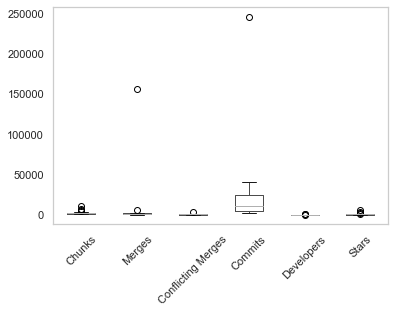

In [23]:
boxplot = table_projects.boxplot(rot=45, grid=False, column=['Chunks', 'Merges', 'Conflicting Merges', 'Commits', 'Developers', 'Stars'])

### LaTeX output

In [24]:
# with pd.option_context("max_colwidth", None):
#   print(table_projects.to_latex(index=False))

with pd.option_context("max_colwidth", None):
  print(table_with_stats.to_latex(index=False, float_format="{:,.0f}".format))

\begin{tabular}{lrrrrrr}
\toprule
                             Project &  Chunks &  Merges &  Conflicting Merges &  Commits &  Developers &  Stars \\
\midrule
                sebastianbenz/Jnario &  10,372 &      32 &                   5 &    1,635 &           8 &     53 \\
                      CCI-MIT/XCoLab &   6,889 &     579 &                 124 &    3,865 &          12 &      4 \\
                     apache/accumulo &   5,141 &   2,548 &                 784 &    8,364 &          56 &    187 \\
aosp-mirror/platform\_frameworks\_base &   4,446 & 156,732 &               3,355 &  246,462 &         115 &  3,286 \\
           TeamDev-Archive/OpenFaces &   3,723 &     611 &                 178 &    3,611 &          16 &      9 \\
                     jgralab/jgralab &   2,590 &     407 &                 101 &    7,871 &          10 &     13 \\
                         alexo/wro4j &   2,078 &   1,458 &                 395 &    4,565 &          37 &    318 \\
               eclipse/jett

## Attributes

In [25]:
attributes = pd.read_csv("../../data/attributes.csv")
attributes

,Category,Attribute,Type,Scope,Name in the dataset,References,Reference source,Details,Reasoning,Easy to retrieve?,How to retrieve,Status
0,Size,Commit authors,Numeric / Discrete,Merge,"Devs 1, Devs 2","Dias et al., 2020; Menezes et al., 2020 (no ge...",Related work,Geometric mean of the number of commit authors...,Attributes that are related to the complexity ...,Yes,Use git to retrieve all commit authors in comm...,Collected
1,Size,Commits,Numeric / Discrete,Merge,"Commits 1, Commits 2","Dias et al., 2020; Lessenich et al., 2018; Men...",Related work,Geometric mean of the number of commits includ...,Attributes that are related to the complexity ...,Yes,Use git to retrieve all commits between the me...,Collected
2,Size,Changed files,Numeric / Discrete,Merge,"Changed files 1, Changed files 2","Dias et al., 2020; Lessenich et al., 2018 (no ...",Related work,Geometric mean of the number of changed files ...,Attributes that are related to the complexity ...,Yes,Use git to retrieve the number of changed file...,Collected
3,Size,Same changed files,Numeric / Discrete,Merge,Changed files intersection,"Owhadi-Kareshk et al., 2019; Ziegler, 2017; K...",Related work,Number of files modified in both branches simu...,Attributes that are related to the complexity ...,Yes,Use git to retrieve the name of changed files ...,Collected
4,Size,Changed lines (code churn),Numeric / Discrete,Merge,"left_lines_added, left_lines_removed, right_li...","Dias et al., 2020; Lessenich et al., 2018; Owh...",Related work,Geometric mean of the number of modified lines...,Attributes that are related to the complexity ...,Yes,Use git to retrieve the number of changed line...,Collected
5,Authorship,Common developers,Numeric / Discrete,Merge,Same devs,"Menezes et al., 2020",Related work,Number of authors that contributed to both bra...,Our hypothesis is that conflicts that are clas...,Yes,Use the author's tool https://github.com/catar...,Collected
6,Authorship,Different developers,Numeric / Discrete,Merge,Different devs,"Menezes et al., 2020",Related work,Number of different authors that participated ...,Attributes that are related to the complexity ...,Yes,Use the author's tool https://github.com/catar...,Collected
7,Authorship,Percentage of self-conflicts,Numeric / Continuous,Chunk,self_conflict_perc,-,Authors' intuition,Percentage of authors that contributed to both...,Our hypothesis is that conflicts that are clas...,Yes,Use our own scripts.,Collected
8,Authorship,Author contribution,Binary,Chunk,One column per author project,-,Authors' intuition,Have the author contributed to any line of the...,Our hypothesis is that the choice of specific ...,Yes,Use our own scripts.,Collected
9,Merge type,Branch merge indicator,Binary,Merge,has_branch_merge_message_indicator,-,Authors' intuition,Does the merge commit message follow a pattern...,Our hypothesis is that explicit merge (branch ...,Yes,Derive from commit message,NaN


In [26]:
attributes_used = attributes[attributes["Name in the dataset"].notna()]
print(f"{attributes_used.shape[0]} atributes used at the dataset.") 

25 atributes used at the dataset.


In [27]:
attributes_used

,Category,Attribute,Type,Scope,Name in the dataset,References,Reference source,Details,Reasoning,Easy to retrieve?,How to retrieve,Status
0,Size,Commit authors,Numeric / Discrete,Merge,"Devs 1, Devs 2","Dias et al., 2020; Menezes et al., 2020 (no ge...",Related work,Geometric mean of the number of commit authors...,Attributes that are related to the complexity ...,Yes,Use git to retrieve all commit authors in comm...,Collected
1,Size,Commits,Numeric / Discrete,Merge,"Commits 1, Commits 2","Dias et al., 2020; Lessenich et al., 2018; Men...",Related work,Geometric mean of the number of commits includ...,Attributes that are related to the complexity ...,Yes,Use git to retrieve all commits between the me...,Collected
2,Size,Changed files,Numeric / Discrete,Merge,"Changed files 1, Changed files 2","Dias et al., 2020; Lessenich et al., 2018 (no ...",Related work,Geometric mean of the number of changed files ...,Attributes that are related to the complexity ...,Yes,Use git to retrieve the number of changed file...,Collected
3,Size,Same changed files,Numeric / Discrete,Merge,Changed files intersection,"Owhadi-Kareshk et al., 2019; Ziegler, 2017; K...",Related work,Number of files modified in both branches simu...,Attributes that are related to the complexity ...,Yes,Use git to retrieve the name of changed files ...,Collected
4,Size,Changed lines (code churn),Numeric / Discrete,Merge,"left_lines_added, left_lines_removed, right_li...","Dias et al., 2020; Lessenich et al., 2018; Owh...",Related work,Geometric mean of the number of modified lines...,Attributes that are related to the complexity ...,Yes,Use git to retrieve the number of changed line...,Collected
5,Authorship,Common developers,Numeric / Discrete,Merge,Same devs,"Menezes et al., 2020",Related work,Number of authors that contributed to both bra...,Our hypothesis is that conflicts that are clas...,Yes,Use the author's tool https://github.com/catar...,Collected
6,Authorship,Different developers,Numeric / Discrete,Merge,Different devs,"Menezes et al., 2020",Related work,Number of different authors that participated ...,Attributes that are related to the complexity ...,Yes,Use the author's tool https://github.com/catar...,Collected
7,Authorship,Percentage of self-conflicts,Numeric / Continuous,Chunk,self_conflict_perc,-,Authors' intuition,Percentage of authors that contributed to both...,Our hypothesis is that conflicts that are clas...,Yes,Use our own scripts.,Collected
8,Authorship,Author contribution,Binary,Chunk,One column per author project,-,Authors' intuition,Have the author contributed to any line of the...,Our hypothesis is that the choice of specific ...,Yes,Use our own scripts.,Collected
9,Merge type,Branch merge indicator,Binary,Merge,has_branch_merge_message_indicator,-,Authors' intuition,Does the merge commit message follow a pattern...,Our hypothesis is that explicit merge (branch ...,Yes,Derive from commit message,NaN


In [28]:
attrs_table = attributes_used[['Category', 'Attribute', 'Type', 'Scope', 'Details']]\
                .sort_values(by=['Category', 'Scope'])\
                .rename(columns={'Details':'Description'})
attrs_table

,Category,Attribute,Type,Scope,Description
7,Authorship,Percentage of self-conflicts,Numeric / Continuous,Chunk,Percentage of authors that contributed to both...
8,Authorship,Author contribution,Binary,Chunk,Have the author contributed to any line of the...
5,Authorship,Common developers,Numeric / Discrete,Merge,Number of authors that contributed to both bra...
6,Authorship,Different developers,Numeric / Discrete,Merge,Number of different authors that participated ...
33,Authorship,Developers intersection,Ordinal,Merge,Degree of intersection of authors between the ...
34,Change-type,Frequency of keywords,Numeric / Discrete,Merge,Frequency of keywords in a commit message that...
20,Complexity,Chunk cyclomatic complexity,Numeric / Discrete,Chunk,Cyclomatic Complexity of a version (left or ri...
21,Complexity,File cyclomatic complexity,Numeric / Discrete,File,Cyclomatic Complexity of the chunk's file.
27,Composition,Constructs,Binary,Chunk,Programming language constructs (e.g. attribut...
26,Location,Chunk position,Numeric / Discrete,Chunk,If we break down the file where the chunk happ...


In [29]:
with pd.option_context("max_colwidth", None):
    txt = attrs_table.to_latex(index=False, float_format="{:,.0f}".format)
    x = re.sub("[ \t]+", " ", txt)
    print(x)

\begin{tabular}{lllll}
\toprule
 Category & Attribute & Type & Scope & Description \\
\midrule
 Authorship & Percentage of self-conflicts & Numeric / Continuous & Chunk & Percentage of authors that contributed to both versions, among all authors who contributed to the chunk. \\
 Authorship & Author contribution & Binary & Chunk & Have the author contributed to any line of the chunk? \\
 Authorship & Common developers & Numeric / Discrete & Merge & Number of authors that contributed to both branches of the merge \\
 Authorship & Different developers & Numeric / Discrete & Merge & Number of different authors that participated in the merge, including all commits between the common ancestor and the merge commit. \\
 Authorship & Developers intersection & Ordinal & Merge & Degree of intersection of authors between the merged branches: no intersection, some intersection, or all developers in common. \\
Change-type & Frequency of keywords & Numeric / Discrete & Merge & Frequency of keywords i